### Project :: Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

Remember the idea behind Evolution Strategies? Here's a neat [blog post](https://blog.openai.com/evolution-strategies/) about 'em.

Can you reproduce their success? You will have to implement evolutionary strategies and see how they work.

This project is optional; has several milestones each worth a number of points [and swag].

__Milestones:__
* [10pts] Basic prototype of evolutionary strategies that works in one thread on CartPole
* [+5pts] Modify the code to make them work in parallel
* [+5pts] if you can run ES distributedly on at least two PCs
* [+10pts] Apply ES to play Atari Pong at least better than random
* [++] Additional points for all kinds of cool stuff besides milestones

__Rules:__

* This is __not a mandatory assignment__, but it's a way to learn some cool things if you're getting bored with default assignments.
* Once you decided to take on this project, please tell any of course staff members so that we can help ypu if you get stuck.
* There's a default implementation of ES in this [openai repo](https://github.com/openai/evolution-strategies-starter). It's okay to look there if you get stuck or want to compare your solutions, but each copy-pasted chunk of code should be understood thoroughly. We'll test that with questions.

### Tips on implementation

* It would be very convenient later if you implemented a function that takes policy weights, generates a session and returns policy changes -- so that you could then run a bunch of them in parallel.

* The simplest way you can do multiprocessing is to use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)

* For joblib, make sure random variables are independent in each job. Simply add `np.random.seed()` at the beginning of your "job" function.

Later once you got distributed, you may need a storage that gathers gradients from all workers. In such case we recommend [Redis](https://redis.io/) due to it's simplicity.

Here's a speed-optimized saver/loader to store numpy arrays in Redis as strings.



## Conclusion
time with joblib for Cart poll not too better in my implementation and model study fast and easy with wide range of parametrs


## Create model with torch

In [56]:
import gym
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from time import time
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [58]:
env = gym.make('CartPole-v0')

In [59]:
class SimpleDense(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self, n_actions=2, obs_shape=4):
        super(SimpleDense, self).__init__()
        
        self.fc1 = torch.nn.Linear(obs_shape, 8)
        self.fc2 = torch.nn.Linear(8, n_actions)
        self.softmax = torch.nn.Softmax(1)
        
    def forward(self, x):
        x = torch.from_numpy(x.reshape(1, 4)).float()
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return torch.argmax(x).numpy()
    
    def get_weights(self):
        """conv, fc1, fc2"""
        return self.fc1.weight, self.fc2.weight
    
    def assign_weights(self, fc1, fc2):
        """input tensor"""
        self.fc1.weight = torch.nn.Parameter(fc1)
        self.fc2.weight = torch.nn.Parameter(fc2)

In [60]:
# Model work
model = SimpleDense()
act = model.forward(env.reset())
print(act)

0


In [61]:
def play_game(model, env, n=100, render=False):
    s = env.reset()
    reward_history = []
    for i in range(n):
        if render:
            env.render()
        s,r,done, _ = env.step(model.forward(s))
        reward_history.append(r)
        if done:
            #print('done')
            #break
            s = env.reset()
            reward_history.append(-10.0)
    return reward_history



In [62]:
def init_source_weights(model_class, n):
    model = model_class()
    source_weights = []
    for weight in model.parameters():
        #print(torch.rand_like(weight.data), weight)
        #return 0
        source_weights.append(weight)#torch.rand_like(weight.data)) # better initialize than just weight
        #print(weight.data.shape)
    return source_weights

def get_update(w1, w2, sigma, model, env, n_games=10):
    jit1 = sigma * torch.rand_like(w1)
    jit2 = sigma * torch.rand_like(w2)
    model.assign_weights(w1 + jit1, w2 + jit2)
    reward = np.sum(play_game(model, env, n_games))
    return jit1, jit2, reward
    

In [63]:
w1 = torch.rand_like(model.fc1.weight)
w2 = torch.rand_like(model.fc2.weight)

get_update(w1, w2, 0.1, model, env) # return jiiter which add to w and reward

(tensor([[0.0076, 0.0225, 0.0062, 0.0182],
         [0.1000, 0.0594, 0.0654, 0.0034],
         [0.0172, 0.0334, 0.0578, 0.0060],
         [0.0285, 0.0201, 0.0501, 0.0314],
         [0.0465, 0.0161, 0.0157, 0.0208],
         [0.0329, 0.0105, 0.0919, 0.0401],
         [0.0930, 0.0656, 0.0077, 0.0846],
         [0.0362, 0.0308, 0.0085, 0.0003]]),
 tensor([[0.0643, 0.0391, 0.0695, 0.0090, 0.0871, 0.0133, 0.0414, 0.0604],
         [0.0758, 0.0904, 0.0955, 0.0104, 0.0626, 0.0285, 0.0445, 0.0126]]),
 0.0)

## About joblib
#joblib part look something like this but work only at "project_starter_evolution_strategies.py" file, here error "core dump"
    #maybe I to stupid to paralel better, but advantage on 4 jobs less then 50%
    res = Parallel(n_jobs=4)(delayed(get_update)(w1, w2, sigma, models[i], env, n_games) for i in range(n))
    for i in range(n):
        w1_stack[:,:,i], w2_stack[:,:,i], reward_stack[i] = res[i]
        


In [64]:
from time import time

n_games = 100
n = 40
epoch = 10
sigma = 0.5
lern_rate = 0.2

try:
    hist_reward.print
except:
    hist_reward = []
    w1 = torch.rand_like(model.fc1.weight)
    w2 = torch.rand_like(model.fc2.weight)
    #w1, w2 = init_source_weights(net_class, n)
shape1 = list(w1.shape)
shape2 = list(w2.shape)
shape1.append(n)
shape2.append(n)
w1_stack = torch.zeros(shape1)
w2_stack = torch.zeros(shape2)
reward_stack = torch.zeros(n)

#assert 1==2
#models = []
#for i in range(n):
#    models.append(SimpleDense())

t = time()    
for j in range(epoch):
    for i in range(n):
        #
        w1_stack[:,:,i], w2_stack[:,:,i], reward_stack[i] = get_update(w1, w2, sigma, SimpleDense(), env, n_games)
         
    
    
    A = (reward_stack - torch.mean(reward_stack)) / (torch.std(reward_stack) + 1e-9)
    w1 += lern_rate * torch.matmul(w1_stack, A) 
    w2 += lern_rate * torch.matmul(w2_stack, A)
    hist_reward.append(sum(reward_stack))
    print('fin epoch ', j, t - time())
    

fin epoch  0 -0.39339160919189453
fin epoch  1 -0.784320592880249
fin epoch  2 -1.173792839050293
fin epoch  3 -1.559722900390625
fin epoch  4 -1.945397138595581
fin epoch  5 -2.3302173614501953
fin epoch  6 -2.713378667831421
fin epoch  7 -3.0980892181396484
fin epoch  8 -3.481095314025879
fin epoch  9 -3.865231990814209


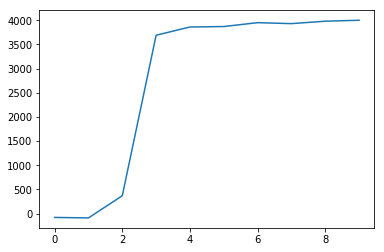

In [65]:

plt.plot(hist_reward)

## Check results

In [66]:
# if results not good run learning block one more time or change n.
model = SimpleDense()
model.assign_weights(w1, w2)
play_game(model, env,n=300, render=True)

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

# Try study on Atari

In [67]:
import joblib
from six import BytesIO
def dumps(data):
    """converts whatever to string"""
    s = BytesIO()
    joblib.dump(data,s)
    return s.getvalue()
        
def loads(self,string):
    """converts string to whatever was dumps'ed in it"""
    return joblib.load(BytesIO(string))


### Tips on atari games
* There's all the pre-processing and tuning done for you in the code below
    * Images rescaled to 42x42 to speed up computation
    * We use last 4 frames as observations to account for ball velocity
    * The code below requires ```pip install Image``` and ```pip install gym[atari]``` 
    * You may also need some dependencies for gym[atari] - google "gym install all" dependencies or use our pre-built environment.
* The recommended agent architecture is a convolutional neural network. Dense network will also do.


May the force be with you!

In [68]:
from pong import make_pong
import numpy as np

env = make_pong()
print(env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Discrete(6)


In [69]:
import random
random.choice([1,3])
p = env.action_space
p.sample(), p.n

(5, 6)

In [70]:
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self, n_actions=6):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(4, 6, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = torch.nn.Linear(6 * 21 * 21, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, n_actions)
        self.softmax = torch.nn.Softmax(1)
        
    def forward(self, x):
        shape = x.shape
        x = torch.from_numpy(x.reshape(1, *shape)).float()
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 6 * 21 * 21)       
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return(x)
    
    

In [71]:
def play_game(model, env, n=100, render=False):
    s = env.reset()
    reward_history = []
    for i in range(n):
        if render:
            env.render()
        action = model.forward(s)
        #print(torch.argmax(action).data)
        s,r,done, _ = env.step(torch.argmax(action))
        reward_history.append(r)
        if done:
            #print('done')
            #break
            s = env.reset()
            reward_history.append(-10.0)
    return reward_history

In [81]:
def init_source_weights(model_class):
    model = model_class()
    source_weights = []
    for weight in model.parameters():
        #print(torch.rand_like(weight.data), weight)
        #return 0
        source_weights.append(weight)#torch.rand_like(weight.data)) # better initialize than just weight
        #print(weight.data.shape)
    return source_weights

def create_jiters_stacks(source_weights, n):
    stacks = []
    for weight in source_weights:
        shape = list(weight.shape)
        shape.append(n)
        #print(shape)
        stacks.append(torch.zeros(shape))
    return stacks
    

def get_update(source_weights, sigma, model, env, n_games=10):
    jitters = []
    for i, weight in enumerate(model.parameters()):
        jitters.append(sigma * torch.rand_like(weight))
        #print(weight.data.shape, source_weights[i].shape, jitters[-1].shape)
        weight.data = source_weights[i] + jitters[-1]
    reward = np.sum(play_game(model, env, n_games)) / n_games
    
    return jitters, reward

In [83]:
from time import time

n_games = 100
n = 20
epoch = 300
sigma = 0.1
lern_rate = 0.001
net_class = SimpleCNN

try:
    hist_reward.print
except:
    hist_reward = []
    source_weights = init_source_weights(net_class)

jitter_stacks = create_jiters_stacks(source_weights, n)
reward_stack = torch.zeros(n)

#models = []
#for i in range(n):
#    models.append(SimpleDense())

t = time()    
for j in range(epoch):
    for i in range(n):
        res, reward_stack[i] = get_update(source_weights, sigma, net_class(), env, n_games)
        for ind_jit, jiter in enumerate(res):
            #print(jitter_stacks[ind_jit].shape, jiter.shape)
            if len(jitter_stacks[ind_jit].shape) == 5:
                jitter_stacks[ind_jit][:,:,:,:,i] = jiter
            elif len(jitter_stacks[ind_jit].shape) == 2:
                jitter_stacks[ind_jit][:,i] = jiter
            else:
                jitter_stacks[ind_jit][:,:,i] = jiter
    
    
    
    A = (reward_stack - torch.mean(reward_stack)) / (torch.std(reward_stack) + 1e-9)
    for ind, weight in enumerate(source_weights):
        source_weights[ind] = weight + lern_rate * torch.matmul(jitter_stacks[ind], A) 
    #w1 += lern_rate * torch.matmul(w1_stack, A) 
    #w2 += lern_rate * torch.matmul(w2_stack, A)
    if np.mean(hist_reward[-10:]) < 0.01:
        source_weights = init_source_weights(net_class)
    hist_reward.append(sum(reward_stack))
    print('fin epoch ', j, t - time())

/home/denis/anaconda3/envs/tourch_gym/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/denis/anaconda3/envs/tourch_gym/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fin epoch  0 -4.8162877559661865
fin epoch  1 -9.230477094650269
fin epoch  2 -13.534797191619873
fin epoch  3 -17.836286067962646
fin epoch  4 -22.16824984550476
fin epoch  5 -26.567870140075684
fin epoch  6 -30.89083433151245
fin epoch  7 -35.18647313117981
fin epoch  8 -39.4929838180542
fin epoch  9 -43.79884457588196
fin epoch  10 -48.11883068084717
fin epoch  11 -52.62646770477295
fin epoch  12 -57.050742387771606
fin epoch  13 -61.438793659210205
fin epoch  14 -65.88739538192749
fin epoch  15 -70.21597146987915
fin epoch  16 -74.5535364151001
fin epoch  17 -79.04186987876892
fin epoch  18 -83.40194845199585
fin epoch  19 -87.7278482913971
fin epoch  20 -92.03249049186707
fin epoch  21 -96.58420729637146
fin epoch  22 -100.88827323913574
fin epoch  23 -105.17864608764648
fin epoch  24 -109.48851132392883
fin epoch  25 -113.76548409461975
fin epoch  26 -118.05824327468872
fin epoch  27 -122.3562867641449
fin epoch  28 -126.65101361274719
fin epoch  29 -130.9274661540985
fin epoch  

fin epoch  243 -1059.3447592258453
fin epoch  244 -1063.5528242588043
fin epoch  245 -1067.7608029842377
fin epoch  246 -1071.9606261253357
fin epoch  247 -1076.3647105693817
fin epoch  248 -1080.5745153427124
fin epoch  249 -1084.7756826877594
fin epoch  250 -1088.9717962741852
fin epoch  251 -1093.1742451190948
fin epoch  252 -1097.3703286647797
fin epoch  253 -1101.748305797577
fin epoch  254 -1106.0025157928467
fin epoch  255 -1110.197478055954
fin epoch  256 -1114.392608165741
fin epoch  257 -1118.5882606506348
fin epoch  258 -1122.7868988513947
fin epoch  259 -1127.1527836322784
fin epoch  260 -1131.4531593322754
fin epoch  261 -1135.7074155807495
fin epoch  262 -1139.9104862213135
fin epoch  263 -1144.1131339073181
fin epoch  264 -1148.3098306655884
fin epoch  265 -1152.671511888504
fin epoch  266 -1156.8605444431305
fin epoch  267 -1161.04975938797
fin epoch  268 -1165.2505512237549
fin epoch  269 -1169.4549267292023
fin epoch  270 -1173.6551713943481
fin epoch  271 -1177.84992

In [84]:
hist_reward[-10:]

[tensor(-0.4000),
 tensor(-0.4000),
 tensor(-0.4000),
 tensor(-0.4000),
 tensor(-0.4000),
 tensor(-0.4000),
 tensor(-0.4000),
 tensor(-0.4000),
 tensor(-0.4000),
 tensor(-0.4000)]

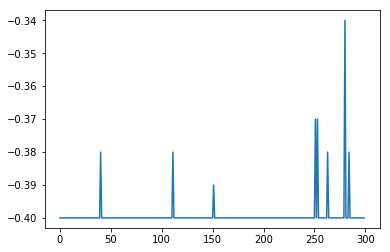

In [85]:
# simple  CNN net
#n_games = 200
#n = 200
#epoch = 3
#sigma = 0.1
#lern_rate = 0.001

plt.plot(hist_reward)

# Full bulshit. Think very small set. 